In [1]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate, GlobalAveragePooling2D
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle5 as pickle
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
seed=2022
tf.random.set_seed(seed)
np.random.seed(seed)

# mfcc

In [3]:
with open("/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/mfcc/mfcc_lst_test.pickle", "rb") as f:
    data = pickle.load(f)
length=[]
for i in range(len(data)):
    length.append(data[i].shape[1])
    
min_len=min(length)

result=[]
for i in range(len(data)):
    result.append(data[i][:,:min_len])
    
result_data=np.array(result)
result_data.shape

(2076, 30, 901)

# codiv-19, feature

In [4]:
y = pd.read_csv("/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/mfcc/Y_data_test.csv").iloc[:,0].values

In [5]:
features = pd.read_csv("/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/csv파일/df_1565_test2.csv")
features = features.iloc[:,[4,5,6,7]]
feature_lst = []
for i in features.index:
    for _ in range(4):
        feature_lst.append(features.iloc[i,:].values)
features = pd.DataFrame(feature_lst)
features.shape

(2076, 4)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(
    result_data, features, stratify = features, test_size = 0.2
)

In [7]:
features_train = Y_train.iloc[:,:-1].values
y_data_train = Y_train.iloc[:,-1].values

In [8]:
features_test = Y_test.iloc[:,:-1].values
y_data_test = Y_test.iloc[:,-1].values

In [9]:
# 각 입력에 대한 형태를 명시
img_input = Input(shape = (30,901,1), name = "features_train")
form_input = Input(shape = (3,), name = "y_data_train")

In [10]:
# 이미지 입력
x_1 = Conv2D(128, (3,3), activation = "relu")(img_input)
x_1 = Conv2D(128, (3,3), activation = "relu")(x_1)
x_1 = MaxPooling2D(strides = 2)(x_1)
x_1 = Dropout(0.25)(x_1)
x_1 = Conv2D(64, (3,3), activation='relu')(x_1)
x_1 = Conv2D(64, (3,3), activation='relu')(x_1)
x_1 = Dropout(0.25)(x_1)
x_1 = GlobalAveragePooling2D()(x_1)

# 피쳐 입력
x_2 = Dense(32, input_dim = 3, activation  = "relu")(form_input)
# x_2 = Dense(32, activation = "relu")(form_input)

x = Concatenate()([x_1, x_2])
rate_pred = Dense(1, name = "covid", activation = "sigmoid")(x)

In [11]:
model = Model(inputs = [img_input, form_input],
              outputs = [rate_pred])

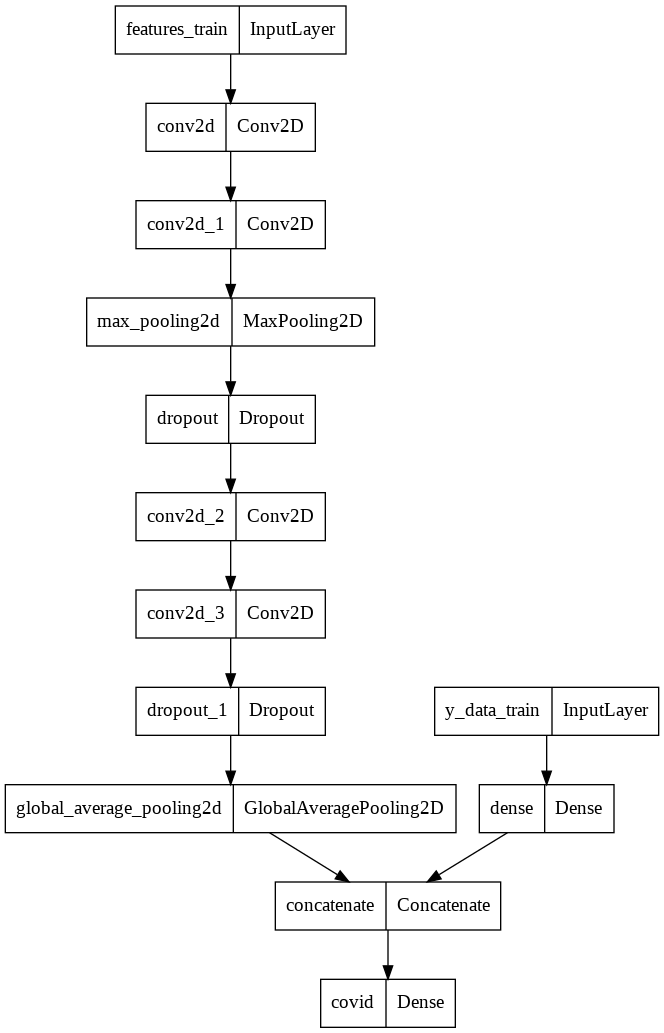

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 features_train (InputLayer)    [(None, 30, 901, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 28, 899, 128  1280        ['features_train[0][0]']         
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 26, 897, 128  147584      ['conv2d[0][0]']                 
                                )                                                             

In [14]:
model.compile(optimizer = "adam",
              loss = "binary_crossentropy", metrics = ["accuracy"])

In [15]:
model_path = "functional-first.h5"
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1, monitor = "val_accuracy")
es = EarlyStopping(patience=10, monitor = "val_accuracy")

In [16]:
hist = model.fit([X_train, features_train] , y_data_train,
                 epochs = 100, batch_size = 150,
                 validation_split=0.2, callbacks = [es, mc])

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 0.8054 - accuracy: 0.4917
Epoch 1: val_accuracy improved from -inf to 0.57229, saving model to functional-first.h5
9/9 [==============================] - 48s 2s/step - loss: 0.8054 - accuracy: 0.4917 - val_loss: 0.6827 - val_accuracy: 0.5723
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 0.6886 - accuracy: 0.5550
Epoch 2: val_accuracy did not improve from 0.57229
9/9 [==============================] - 10s 1s/step - loss: 0.6886 - accuracy: 0.5550 - val_loss: 0.6846 - val_accuracy: 0.5693
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.5587
Epoch 3: val_accuracy did not improve from 0.57229
9/9 [==============================] - 10s 1s/step - loss: 0.6848 - accuracy: 0.5587 - val_loss: 0.6746 - val_accuracy: 0.5723
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.6828 - accuracy: 0.5572
Epoch 4: val_accuracy did not improve from 0.57229
9/9 [

In [17]:
best_model = load_model(model_path)
best_model.evaluate([X_test, features_test], y_data_test)

13/13 [==============================] - 1s 62ms/step - loss: 0.6427 - accuracy: 0.6274


[0.6426677703857422, 0.6274038553237915]

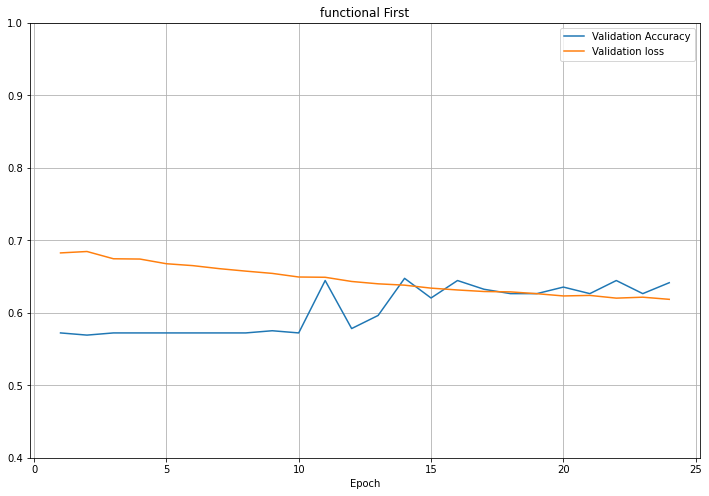

In [18]:
import matplotlib.pyplot as plt

y_acc = hist.history["val_accuracy"]
y_vloss = hist.history["val_loss"]
xs = np.arange(1, len(y_acc) + 1)

plt.figure(figsize = (12,8))
plt.plot(xs, y_acc, label = "Validation Accuracy")
plt.plot(xs, y_vloss, label = "Validation loss")
plt.legend(), plt.grid(), plt.xlabel("Epoch"), plt.title("functional First"), plt.ylim([0.4,1])
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
y_train_pred=best_model.predict([X_test, features_test])
yhat=[]
for data in y_train_pred:
  if data>=0.5:
    yhat.append(1)
  else:
    yhat.append(0)
yhat

In [20]:
cf = confusion_matrix(y_data_test, yhat)
print(cf)

[[146  38]
 [117 115]]


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score
p = precision_score(y_data_test, yhat)
print(p)
r = recall_score(y_data_test, yhat)
print(r)
f1 = f1_score(y_data_test, yhat)
print(f1)

0.7516339869281046
0.4956896551724138
0.5974025974025975


# train_test dataset에 없는 다른 데이터로 모델 테스트

In [22]:
with open("/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/test/fffff.pickle", "rb") as f:
    data = pickle.load(f)
length=[]
for i in range(len(data)):
    length.append(data[i].shape[1])
    
min_len=min(length)

result=[]
for i in range(len(data)):
    result.append(data[i][:,:min_len])
    
result_data_other=np.array(result)
result_data_other.shape

(520, 30, 901)

In [23]:
features_other = pd.read_csv("/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/test/test_df_15세65세_aug전.csv")
features_other = features_other.iloc[:,[4,5,6,7]]
features_other

,man,respiratory_condition,fever_muscle_pain,COVID-19
0,1,1,0,0
1,1,1,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
515,0,0,1,1
516,0,0,0,1
517,0,0,0,1
518,0,0,1,1


In [24]:
feature_test_data = features_other.iloc[:,:-1].values
y_test_data = features_other.iloc[:,-1].values

In [25]:
y_train_pred=model.predict([result_data_other, feature_test_data])
yhat_test=[]
for data in y_train_pred:
  if data>=0.5:
    yhat_test.append(1)
  else:
    yhat_test.append(0)


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score
p = precision_score(y_test_data, yhat_test)
print(p)
r = recall_score(y_test_data, yhat_test)
print(r)
f1 = f1_score(y_test_data, yhat_test)
print(f1)

0.5930232558139535
0.5884615384615385
0.5907335907335908


In [27]:
model.evaluate([result_data_other, feature_test_data], y_test_data)

17/17 [==============================] - 1s 60ms/step - loss: 0.6768 - accuracy: 0.5923


[0.6767964959144592, 0.5923076868057251]